# **Projet Data Mining**

# Collecte de données

Nous allons pour commencer télécharger des images dans une base de données, nous avons utilisé Kaggle pour cela. Et nous traiterons des images de chats/chatons.

In [1]:
import ssl
import os
import requests
import time

# Désactiver la vérification du certificat SSL
ssl._create_default_https_context = ssl._create_unverified_context

import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from requests.exceptions import HTTPError

endpoint_url = "https://query.wikidata.org/sparql"

# Get cats
query = """
        SELECT DISTINCT ?cat ?image WHERE {
            ?cat wdt:P31 wd:Q146.
            ?cat wdt:P18 ?image.
        }
        LIMIT 100"""


def get_results(endpoint_url, query):
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def download_image(image_url, filename):
    # Fonction pour télécharger une image à partir de son URL
    try:
        response = requests.get(image_url, headers={"User-Agent": "Mozilla/5.0"})
        response.raise_for_status()  # Vérifier si la requête a réussi
        with open(filename, 'wb') as file:
            file.write(response.content)
    except HTTPError as http_err:
        print(f"Erreur HTTP lors du téléchargement de {image_url}: {http_err}")
        print("Contenu de la réponse (si disponible):", response.content)
    except requests.exceptions.RequestException as e:
        print(f"Erreur lors du téléchargement de {image_url}: {e}")
    except Exception as e:
        print(f"Une erreur s'est produite lors du téléchargement de {image_url}: {e}")


array = []
results = get_results(endpoint_url, query)

# Créer un dossier pour enregistrer les images s'il n'existe pas
if not os.path.exists('cat_images'):
    os.makedirs('cat_images')

for result in results["results"]["bindings"]:
    cat_name = result["cat"]["value"]
    image_url = result["image"]["value"]
    
    # Ajouter le nom du fichier à partir de l'URL
    image_filename = 'cat_images/{}.jpg'.format(cat_name.split('/')[-1])
    
    # Ajouter le nom du fichier à la liste
    array.append((cat_name, image_filename))
    
    # Télécharger l'image dans le dossier 'cat_images'
    download_image(image_url, image_filename)
    
    # Ajouter un délai entre les téléchargements pour ne pas surcharger le serveur distant
    time.sleep(1)

print("Tous les téléchargements sont terminés.")


Tous les téléchargements sont terminés.


Code pour reccuperer le format d'une image

In [2]:
def getformat(image):
    # Permets de récupérer le format d'une image
    imgfile = Image.open(image)
    long = imgfile.size[0]
    larg = imgfile.size[1]
    if long > larg:
        format = "paysage"
    elif larg > long:
        format = "portrait"
    else:  
        format = "carre"
    return format

Code pour reccuperer les couleurs dominante des images

In [12]:
import numpy
from sklearn.cluster import MiniBatchKMeans

def getcolors(image):
    n_clusters = 2
    imgfile = Image.open(image)
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    clusters = MiniBatchKMeans(n_clusters,n_init = 'auto')
    clusters.fit(numarray)
    npbins = numpy.arange(0, n_clusters + 1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)

    hist_decres = sorted(histogram[0], reverse=True)

    colors = []

    for i in range(n_clusters):
        colors.append([int(clusters.cluster_centers_[i][0]),int(clusters.cluster_centers_[i][1]),int(clusters.cluster_centers_[i][2])])

    return colors

Nous ne telechargeons pas les exif pour les images qui en ont pour une question d'homogeneité des fichier .json , mais voici comment nous l'aurions fait si nous avions choisis cette méthode.

In [ ]:
'''import os
import json
from PIL import Image, UnidentifiedImageError
from PIL.ExifTags import TAGS

chemin_image = './cat_images'

def convert_ifd_rational(value):
    """
    Convertir les valeurs IFDRational en tuple (numérateur, dénominateur).
    """
    if not isinstance(value, tuple):
        return value
    
    rational_values = []
    for v in value:
        try:
            rational_values.append(int(v))
        except (ValueError, TypeError):
            # Si la valeur n'est pas un nombre, garder la valeur d'origine
            rational_values.append(v)
    
    return tuple(rational_values)

for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg'):
        filepath = os.path.join(chemin_image, fichier)
        try:
            imgfile = Image.open(filepath)
            # Récupérer les métadonnées EXIF
            exif_data = imgfile._getexif()
            if exif_data is None:
                print(f"Aucune métadonnée EXIF disponible pour l'image {fichier}.")
            else:
                exif_dict = {}
                for tag, value in exif_data.items():
                    if tag in TAGS:
                        # Convertir les valeurs IFDRational en tuple (numérateur, dénominateur)
                        value = convert_ifd_rational(value)
                        exif_dict[TAGS[tag]] = value
                    else:
                        # Pour les tags non standard, les enregistrer avec un préfixe "Tag_"
                        exif_dict[f"Tag_{tag}"] = value
                
                # Créer un fichier JSON avec les informations EXIF
                json_filename = os.path.splitext(filepath)[0] + '.json'
                with open(json_filename, 'w') as json_file:
                    # Utiliser un encodeur personnalisé pour gérer les types non sérialisables
                    json.dump(exif_dict, json_file, indent=4, default=str)
                
                
            imgfile.close()  # Fermer le fichier après avoir terminé
        except (OSError, AttributeError, UnidentifiedImageError) as e:
            print(f"Impossible de traiter l'image {fichier}: {e}")'''


'import os\nimport json\nfrom PIL import Image, UnidentifiedImageError\nfrom PIL.ExifTags import TAGS\n\nchemin_image = \'./cat_images\'\n\ndef convert_ifd_rational(value):\n    """\n    Convertir les valeurs IFDRational en tuple (numérateur, dénominateur).\n    """\n    if not isinstance(value, tuple):\n        return value\n    \n    rational_values = []\n    for v in value:\n        try:\n            rational_values.append(int(v))\n        except (ValueError, TypeError):\n            # Si la valeur n\'est pas un nombre, garder la valeur d\'origine\n            rational_values.append(v)\n    \n    return tuple(rational_values)\n\nfor fichier in os.listdir(chemin_image):\n    if fichier.endswith(\'.jpg\'):\n        filepath = os.path.join(chemin_image, fichier)\n        try:\n            imgfile = Image.open(filepath)\n            # Récupérer les métadonnées EXIF\n            exif_data = imgfile._getexif()\n            if exif_data is None:\n                print(f"Aucune métadonnée E

Nous n'avons pas d'exif pour toutes les images, donc nous passons par cette méthode:

In [13]:
import os
from PIL import Image
from PIL.ExifTags import TAGS
import json 

chemin_images = './cat_images'

for fichier in os.listdir(chemin_images):
    if fichier.endswith('.jpg'):
        filepath = os.path.join(chemin_images, fichier)
        json_filename = os.path.splitext(filepath)[0] + '.json'    
        try:
            #couleurs= getcolors(filepath)
            metadata = {
                        'file_name': fichier,
                        'size': os.path.getsize(filepath),
                        'format': getformat(filepath),
                        'mode': Image.open(filepath).mode,
                        'color': getcolors(filepath)
                    }

                    # Écrire les métadonnées dans le fichier JSON
            with open(json_filename, 'w') as f:
                    json.dump(metadata, f, indent=4)

        except (OSError, AttributeError) as e:
            print(f"Impossible de traiter l'image {fichier}: {e}")



Nous enregistrons des tags pour chaque image

In [3]:
import os
import json
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

# Chemin du dossier contenant les images
chemin_images = './cat_images'

# Liste des noms de fichiers des images
images_list = [file for file in os.listdir(chemin_images) if file.endswith('.jpg')]
num_images = len(images_list)

# Index de l'image actuellement affichée
current_index = 0

# Widget pour l'image
image_widget = widgets.Image(
    format='jpg',
    width=400,
    height=400
)

# Widget pour le champ de saisie du tag
tag_input = widgets.Text(placeholder='Ajouter un tag', description='Tag:')
tag_output = widgets.Output()

# Fonction pour afficher l'image et le champ de saisie de tag
def display_image(index):
    global current_index
    current_index = index % num_images
    image_path = os.path.join(chemin_images, images_list[current_index])
    with open(image_path, "rb") as f:
        image_widget.value = f.read()
    tag_input.value = ''  # Réinitialiser le champ de saisie du tag
    with tag_output:
        clear_output()
        print(f"Image {current_index + 1}/{num_images}: {images_list[current_index]}")
    
    # Charger les tags existants ou créer un dictionnaire vide
    json_filename = os.path.splitext(images_list[current_index])[0] + '.json'
    json_path = os.path.join(chemin_images, json_filename)
    tags_dict = {}
    if os.path.exists(json_path):
        with open(json_path, 'r') as json_file:
            tags_dict = json.load(json_file)
    
    # Afficher les tags existants pour cette image
    print("Tags existants pour cette image : ", tags_dict)
    
    display(image_widget, tag_input, tag_output)

# Fonction pour gérer le changement d'image et enregistrer le tag
def on_button_clicked(b):
    global current_index
    tag = tag_input.value.strip()
    
    # Charger les tags existants ou créer un dictionnaire vide
    json_filename = os.path.splitext(images_list[current_index])[0] + '.json'
    json_path = os.path.join(chemin_images, json_filename)
    tags_dict = {}
    if os.path.exists(json_path):
        with open(json_path, 'r') as json_file:
            tags_dict = json.load(json_file)
    
    # Ajouter le nouveau tag
    tags_dict[current_index] = tag
    
    # Écrire les tags dans le fichier JSON
    with open(json_path, 'w') as json_file:
        json.dump(tags_dict, json_file, indent=4)
    
    # Afficher un message de confirmation
    with tag_output:

        print(f"Tag '{tag}' ajouté pour l'image {current_index + 1}")
    clear_output()
    display(next_button)
    current_index += 1
    display_image(current_index)

# Bouton pour passer à l'image suivante et enregistrer le tag
next_button = widgets.Button(description='Image suivante')
next_button.on_click(on_button_clicked)

# Afficher la première image au démarrage
display_image(current_index)

# Afficher le bouton pour passer à l'image suivante
display(next_button)


Tags existants pour cette image :  {'file_name': 'Q106828517.jpg', 'size': 2128764, 'format': 'paysage', 'mode': 'RGB', 'color': [[31, 13, 2], [130, 75, 29]]}


Image(value=b'\xff\xd8\xff\xe1\xa2~Exif\x00\x00II*\x00\x08\x00\x00\x00\x0c\x00\x0e\x01\x02\x00 \x00\x00\x00\x9…

Text(value='', description='Tag:', placeholder='Ajouter un tag')

Output(outputs=({'name': 'stdout', 'text': 'Image 1/54: Q105330885.jpg\n', 'output_type': 'stream'},))

# Analyses de données

Gerer les utilisateurs 

In [6]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

# Widget pour saisir le nom
nom_input = widgets.Text(placeholder='Entrez votre nom', description='Nom:')
submit_button = widgets.Button(description='Soumettre')

# Widget pour afficher le message de bienvenue
message_output = widgets.Output()

def on_submit_button_clicked(b):
    nom = nom_input.value.strip()
    if nom:
        # Créer un dossier avec le nom de l'utilisateur s'il n'existe pas
        user_folder = os.path.join('./', nom)
        if not os.path.exists(user_folder):
            os.makedirs(user_folder)
            with message_output:
                clear_output()
                print(f"Dossier '{nom}' créé avec succès.")

        with message_output:
            clear_output()
            print(f"Bonjour {nom} ! Bienvenue. Votre dossier '{nom}' a été créé.")

    else:
        with message_output:
            clear_output()
            print("Veuillez saisir votre nom.")

# Lier la fonction au clic sur le bouton Soumettre
submit_button.on_click(on_submit_button_clicked)

# Afficher le formulaire
display(nom_input, submit_button, message_output)


Text(value='', description='Nom:', placeholder='Entrez votre nom')

Button(description='Soumettre', style=ButtonStyle())

Output()

Après avoir reccuperé les données nous demondons aux utilisateurs de choisir des images

In [7]:
import ipywidgets as widgets
import os, sys
from PIL import Image
import json

from os import listdir

chemin_image='./cat_images'
images = []
limite= 20

for count, file in enumerate(os.listdir(chemin_image)):
    if count >= limite:
        break  # Sort de la boucle une fois la limite atteinte
    if file.endswith('.jpg') :
        images.append("./cat_images/" + file)

from ipywidgets import GridspecLayout, Image, interact
paths = []

checkboxes = [widgets.Checkbox(value=False, description='Favorite') for _ in range(len(images))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=len(images), width='400px')
for i, (img, checkbox) in enumerate(zip(images, checkboxes)):
  file = open(img, "rb")
  image = file.read()
  image_widget = widgets.Image(
    value=image,
    format='png',
    width=100,
    height=100,
  )
  layout[i,0] = image_widget
  layout[i, 1] = checkbox

nom_utilisateur = widgets.Text(placeholder='Nom d\'utilisateur', description='Nom:')

# Button to get selected images
button = widgets.Button(description="Select")

# Output widget to display selected images
output = widgets.Output()

# Function to get selected images
def get_selected_images(btn):
    global paths
    paths = []
    selected_paths = [images[i] for i, checkbox in enumerate(checkboxes) if checkbox.value]
    with output:
        output.clear_output()
        print("Selected Images:")
        for path in selected_paths:
            print(path)
            paths.append(path)
    print(paths)

    # Écrire la liste dans le fichier favoris de l'utilisateur 
    utilisateur = nom_utilisateur.value.strip()
    if utilisateur:
        dossier_utilisateur = os.path.join('./', utilisateur)
        # Vérifier si le dossier de l'utilisateur existe
        if os.path.exists(dossier_utilisateur):
            # Créer le dossier "favoris" s'il n'existe pas
            dossier_favoris = os.path.join(dossier_utilisateur, 'favoris')
            if not os.path.exists(dossier_favoris):
                os.makedirs(dossier_favoris)

            json_favoris = os.path.join(dossier_favoris, 'favoris.json')
            with open(json_favoris, 'w') as f:
              json.dump(paths, f)
        

# Link button click event to function
button.on_click(get_selected_images)

# Display the layout and button
display(nom_utilisateur, layout, button, output)

Text(value='', description='Nom:', placeholder="Nom d'utilisateur")

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\…

Button(description='Select', style=ButtonStyle())

Output()

['./cat_images/Q54087698.jpg', './cat_images/Q28665865.jpg']


Nous faisons le choix d'utiliser la classification algorithmique 

In [8]:
import os
import json
import numpy as np
from PIL import Image
from ipywidgets import Image as ImageWidget, HBox, VBox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Charger les métadonnées des images du dossier cat_images
def load_image_metadata():
    image_metadata = {}
    chemin_images = './cat_images'
    for file in os.listdir(chemin_images):
        if file.endswith('.json'):
            with open(os.path.join(chemin_images, file), 'r') as f:
                metadata = json.load(f)
                image_metadata[file] = metadata
    return image_metadata

# Charger les images favorites de l'utilisateur
def load_favorite_images(utilisateur):
    favoris_path = os.path.join('./', utilisateur, 'favoris', 'favoris.json')
    with open(favoris_path, 'r') as f:
        liste_fichiers = json.load(f)
    return liste_fichiers

# Vérifier si les caractéristiques sont similaires
def check_similarity(metadata1, metadata2):
    similarity = True
    if metadata1['format'] != metadata2['format']:
        similarity = False
    if metadata1['mode'] != metadata2['mode']:
        similarity = False
    return similarity

# Fonction principale pour recommander les images
def recommendation(btn):
    utilisateur = nom_utilisateur.value.strip()
    if utilisateur:
        image_metadata = load_image_metadata()
        liste_fichiers = load_favorite_images(utilisateur)

        # Récupérer les métadonnées des images favorites
        for i,val in enumerate(liste_fichiers):
          liste_fichiers[i] = os.path.basename(val)

        #favorites_metadata = [image_metadata[file] for file in liste_fichiers if file in image_metadata]
        favorites_metadata = []
        for image_file in liste_fichiers:
          # Construire le nom du fichier JSON correspondant
            json_file = os.path.splitext(image_file)[0] + '.json'

                        # Vérifier si le fichier JSON existe dans image_metadata
            if json_file in image_metadata:
                      # Accéder aux données du fichier JSON correspondant
                metadata = image_metadata[json_file]
                favorites_metadata.append(metadata)


        # Filtrer les images similaires aux favoris
        similar_images = []
        for metadata,filename in image_metadata.items():
            if filename not in liste_fichiers:
                for fav_metadata in favorites_metadata:
                    if check_similarity(image_metadata[metadata], fav_metadata):
                        similar_images.append(filename)
                        break
        # Afficher les images similaires
        display_similar_images(similar_images, utilisateur)
    else:
        print("Veuillez saisir le nom d'utilisateur.")

# Afficher les images similaires
def display_similar_images(images, utilisateur):
    if not images:
        print("Aucune recommandation trouvée.")
        return
    image_widgets = []
    for image in images:
        with open(os.path.join('./cat_images', image["file_name"]), 'rb') as f:
            img = Image.open(f)
            img_widget = ImageWidget(value=f.read(), format='jpg', width=200, height=200)
            image_widgets.append(img_widget)

    images_per_row = 3
    rows = [HBox(image_widgets[i:i+images_per_row]) for i in range(0, len(image_widgets), images_per_row)]

    # Classifier pour prédire si l'image devrait être un favori
   
    for i,val in enumerate(images):
       images[i] = val["file_name"]
    image_metadata = load_image_metadata()

    X = [[['size'], metadata['format']] for metadata in [image_metadata[image] for image in images]]
    y = [1] * len(images)  # Toutes les images recommandées sont considérées comme favorites
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    label_encoders = [LabelEncoder() for _ in range(3)]
    X_train_encoded = [[encoder.fit_transform([feat]) for encoder, feat in zip(label_encoders, row)] for row in X_train]
    X_train_encoded = [[val for sublist in row for val in sublist] for row in X_train_encoded]

    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train_encoded, y_train)

    X_test_encoded = [[encoder.transform([feat]) for encoder, feat in zip(label_encoders, row)] for row in X_test]
    X_test_encoded = [[val for sublist in row for val in sublist] for row in X_test_encoded]

    predictions = classifier.predict(X_test_encoded)

    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy of RandomForestClassifier: {accuracy}")

    for row in rows:
        display(row)

# Widgets et bouton
nom_utilisateur = widgets.Text(placeholder="Nom d'utilisateur", description="Nom:")
button = widgets.Button(description="Recommander")

# Lier le bouton à la fonction de recommandation
button.on_click(recommendation)

# Affichage des widgets
display(nom_utilisateur, button)



Text(value='', description='Nom:', placeholder="Nom d'utilisateur")

Button(description='Recommander', style=ButtonStyle())

Aucune recommandation trouvée.


# Visualisation des données

Visualisation en histogrammes des couleurs des images favorite

Text(value='', description='Nom:', placeholder="Nom d'utilisateur")

Button(description='Visualisation', style=ButtonStyle())

./cat_images/Q25171691.jpg


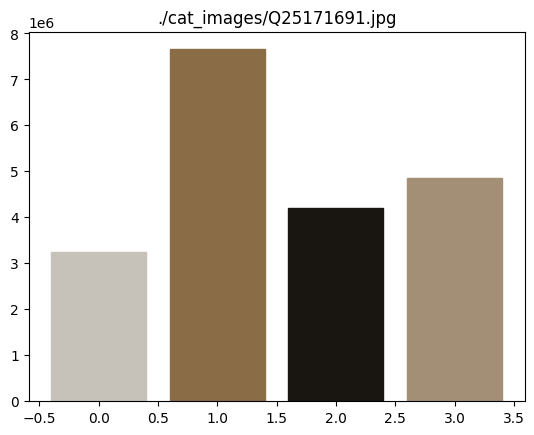

./cat_images/Q27190410.jpg


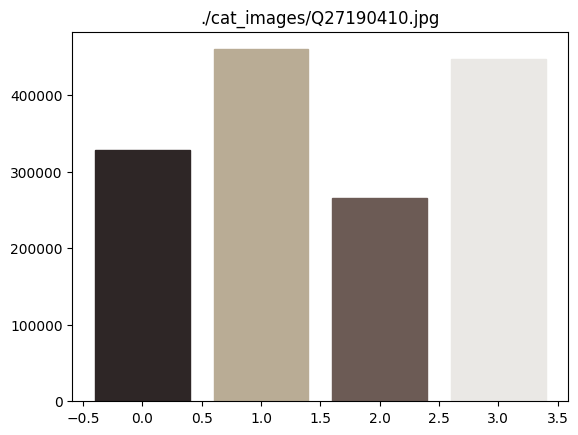

In [20]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
import os
from sklearn.cluster import KMeans
import json
import ipywidgets as widgets

chemin_image = ''

# Charger les images favorites de l'utilisateur
def load_favorite_images(utilisateur):
    favoris_path = os.path.join('./', utilisateur, 'favoris', 'favoris.json')
    with open(favoris_path, 'r') as f:
        liste_fichiers = json.load(f)
    # Ajouter le chemin de base pour chaque fichier
    liste_fichiers = [os.path.join(chemin_image, f) for f in liste_fichiers]
    return liste_fichiers

def visualisation(btn):
    utilisateur = nom_utilisateur.value.strip()
    if utilisateur:
        liste_fichiers = load_favorite_images(utilisateur)

        for filepath in liste_fichiers:
            if filepath.endswith('.jpg'):
                imgfile = Image.open(filepath)
                numarray = numpy.array(imgfile.getdata(), numpy.uint8)
                clusters = KMeans(n_clusters=4, n_init=2)
                clusters.fit(numarray)
                npbins = numpy.arange(0, 5)
                histogram = numpy.histogram(clusters.labels_, bins=npbins)
                labels = numpy.unique(clusters.labels_)
                barlist = plot.bar(labels, histogram[0])
                for i in range(4):
                    barlist[i].set_color(
                        "#%02x%02x%02x"
                        % (
                            math.ceil(clusters.cluster_centers_[i][0]),
                            math.ceil(clusters.cluster_centers_[i][1]),
                            math.ceil(clusters.cluster_centers_[i][2]),
                        )
                    )
                plot.title(filepath, loc='center')
                plot.show()

# Widgets et bouton
nom_utilisateur = widgets.Text(placeholder="Nom d'utilisateur", description="Nom:")
button = widgets.Button(description="Visualisation")

# Lier le bouton à la fonction de recommandation
button.on_click(visualisation)

# Affichage des widgets
display(nom_utilisateur, button)



Visualisation en graphique des couleurs des images favorite

Text(value='', description='Nom:', placeholder="Nom d'utilisateur")

Button(description='Visualisation', style=ButtonStyle())

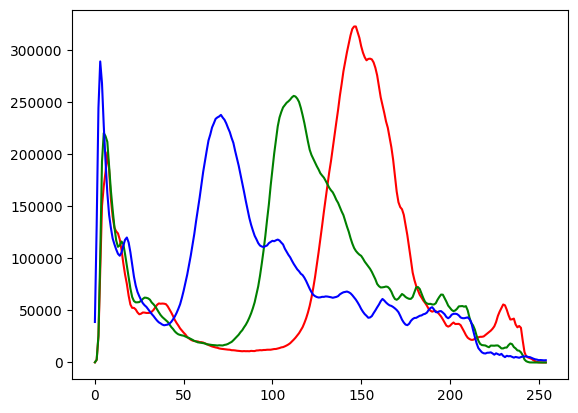

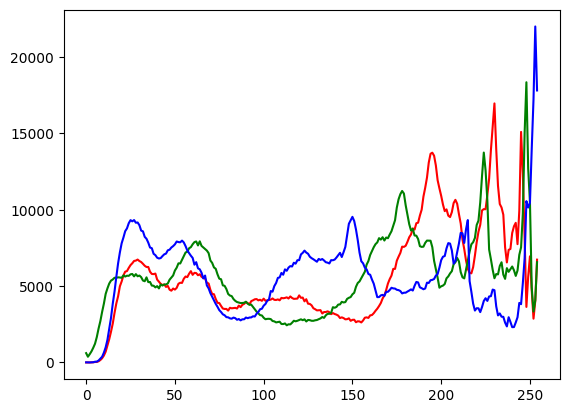

In [23]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
import os
from sklearn.cluster import KMeans

chemin_image = ''

# Charger les images favorites de l'utilisateur
def load_favorite_images(utilisateur):
    favoris_path = os.path.join('./', utilisateur, 'favoris', 'favoris.json')
    with open(favoris_path, 'r') as f:
        liste_fichiers = json.load(f)
    # Ajouter le chemin de base pour chaque fichier
    liste_fichiers = [os.path.join(chemin_image, f) for f in liste_fichiers]
    return liste_fichiers

def visualisation(btn):
    utilisateur = nom_utilisateur.value.strip()
    if utilisateur:
        liste_fichiers = load_favorite_images(utilisateur)

        for filepath in liste_fichiers:
            if filepath.endswith('.jpg') :
                imgfile = Image.open(filepath)
                histogram = imgfile.histogram()
                red = histogram[0:255]
                green = histogram[256:511]
                blue = histogram[512:767]
                x = range(255)
                y = []
                for i in x:
                    y.append((red[i], green[i], blue[i]))
                figure, axes = plot.subplots()
                axes.set_prop_cycle("color", ["red", "green", "blue"])
                plot.plot(x, y)
                plot.show()


# Widgets et bouton
nom_utilisateur = widgets.Text(placeholder="Nom d'utilisateur", description="Nom:")
button = widgets.Button(description="Visualisation")

# Lier le bouton à la fonction de recommandation
button.on_click(visualisation)

# Affichage des widgets
display(nom_utilisateur, button)
